In [234]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

In [235]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(10,5)})

In [236]:
n_steps = 64

n=64
v=10
d=8

w_shape = (d,d)
a_shape = (v,v)
f_shape = (n,v,d)

In [237]:
def generate_matrix(dim,sign=1):
    V = np.diag(sign*np.random.rand(dim))
    Q = np.random.normal(0,0.1,(dim,dim))
    return Q@V@np.linalg.inv(Q)

def diffusion_step(F,A,W,tau=1):
    return tau*np.einsum('kv,nvd -> nkd',A,np.einsum('nvd,dk -> nvk',F,W)) + F

def diffusion_stepFT(F,A,W,tau=0.5):
    return tau*np.einsum('kv,nvd -> nkd',A,np.einsum('nvd,dk -> nvk',F,W)) + (1-tau)*F

def diffusion_stepI(F,A,W,tau=1):
    return tau*np.einsum('kv,nvd -> nkd',A-np.eye(A.shape[0]),np.einsum('nvd,dk -> nvk',F,W)) + F

def diffusion_stepIFT(F,A,W,tau=1):
    return tau*np.einsum('kv,nvd -> nkd',A-np.eye(A.shape[0]),np.einsum('nvd,dk -> nvk',F,W)) + (1-tau)*F

def diffuse(F0,As,Ws,step_fn,tau=1):
    assert len(As) == len(Ws), "As and Ws must be of same length"
    
    outputs = [F0]
    for A,W in zip(As,Ws):
        outputs.append(step_fn(outputs[-1],A,W,tau))
    
    return outputs

def get_similarities(outputs):
    similarities = []
    batch_size = outputs[0].shape[0]
    dim = outputs[0].shape[1]
    for output in outputs:
        similarities.append(
            np.sum(np.fromiter((cosine_similarity(output[k]).mean() for k in range(dim)), float))/batch_size
        )
        
    return similarities 

def plot_similarities(sims):
    plt.plot(sims, linestyle=':', marker='P', markersize=5)
    plt.ylabel("Average node similarities")
    plt.xlabel("Diffusion steps")
    plt.show()
    
def get_differences(outputs):
    differences = []
    for k in range(len(outputs)-1):
        differences.append(np.linalg.norm(outputs[k+1])/np.linalg.norm(outputs[k]))
        
    return differences 

def plot_differences(diffs):
    plt.plot(diffs, linestyle=':', marker='P', color='r', markersize=5)
    plt.ylabel("Max node difference")
    plt.xlabel("Diffusion steps")
    plt.show()

# $\mathbf{F}(t+1) = \tau \mathbf{A}(\mathbf{F}(t))\mathbf{F}(t)\mathbf{W}(t) + \mathbf{F}(t)$

In [107]:
As =[
    scipy.special.softmax(np.random.normal(0,1,a_shape), axis=0) for _ in range(n_steps)
]

Ws =[
    generate_matrix(d,-1) for _ in range(n_steps) #np.random.normal(0,1,w_shape)
]

F0 = np.random.normal(0,1,f_shape)

In [184]:
eigs = np.linalg.eigvals(Ws[0])
for e in eigs: print(e)

(0.12500000000000006+0j)
(-0.008941810374049567+0.006207322519526948j)
(-0.008941810374049567-0.006207322519526948j)
(-0.007443909614024906+0.0014416011407447236j)
(-0.007443909614024906-0.0014416011407447236j)
(-0.0017443601629466108+0.000972591075060071j)
(-0.0017443601629466108-0.000972591075060071j)
(-0.0029349461902661318+0j)


In [253]:
outputs = diffuse(F0,As,Ws,diffusion_step,tau=1)

## Oversmoothing

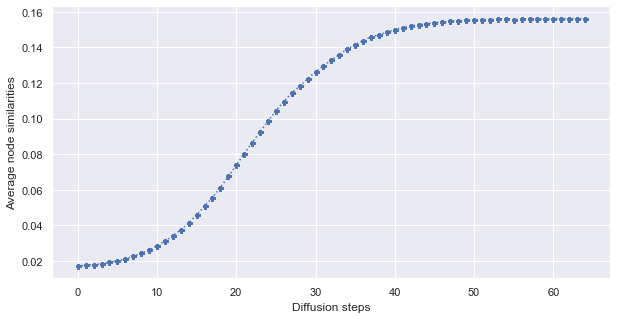

In [254]:
similarities = get_similarities(outputs)
plot_similarities(similarities)

## Stability

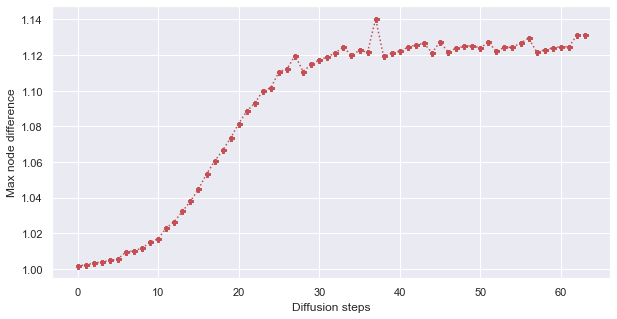

In [255]:
differences = get_differences(outputs)
plot_differences(differences)

# $\mathbf{F}(t+1) = \tau \mathbf{A}(\mathbf{F}(t))\mathbf{F}(t)\mathbf{W}(t) + (1 - \tau) \mathbf{F}(t)$

In [239]:
As =[
    scipy.special.softmax(np.random.normal(0,1,a_shape), axis=0) for _ in range(n_steps)
]

Ws =[
    #scipy.special.softmax(np.random.normal(0,0.1,w_shape), axis=1)/w_shape[1] for _ in range(n_steps)
    scipy.special.softmax(generate_matrix(d,-1), axis=1)/w_shape[1] for _ in range(n_steps)
]
#for W in Ws: W = 0.5*(W+W.T)

F0 = np.random.normal(0,1,f_shape)

In [240]:
eigs = np.linalg.eigvals(Ws[0])
for e in eigs: print(e)

(0.12499999999999994+0j)
(-0.03728703701453829+0j)
(0.0009577015668646503+0.014085616357698331j)
(0.0009577015668646503-0.014085616357698331j)
(-0.011327554077354373+0.006019483365176758j)
(-0.011327554077354373-0.006019483365176758j)
(-0.006787383688314924+0j)
(0.0016339330777388186+0j)


In [241]:
outputs = diffuse(F0,As,Ws,diffusion_stepFT,tau=0.5)

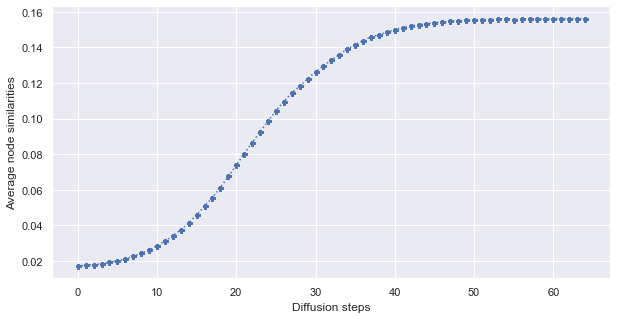

In [242]:
similarities = get_similarities(outputs)
plot_similarities(similarities)

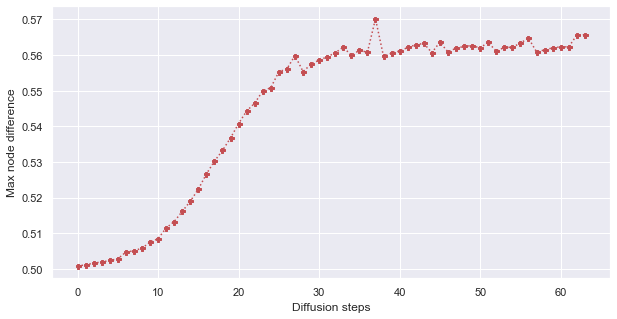

In [243]:
differences = get_differences(outputs)
plot_differences(differences)

In [244]:
outputs = diffuse(F0,As,Ws,diffusion_stepFT,tau=1)

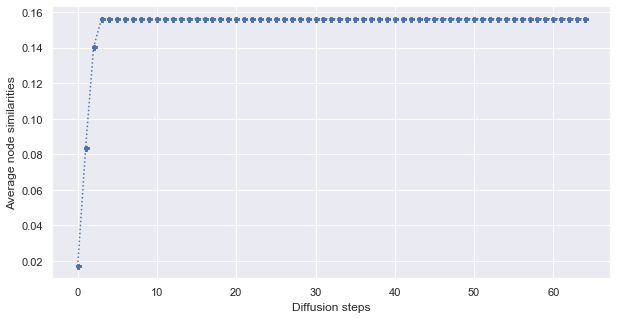

In [245]:
similarities = get_similarities(outputs)
plot_similarities(similarities)

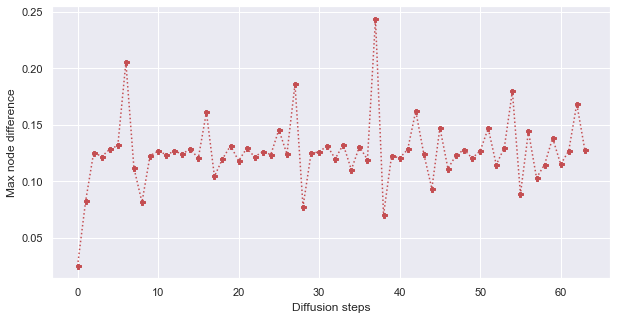

In [246]:
differences = get_differences(outputs)
plot_differences(differences)

# $\mathbf{F}(t+1) = \tau \bar{\mathbf{A}}(\mathbf{F}(t))\mathbf{F}(t)\mathbf{W}(t) + \mathbf{F}(t)$

In [247]:
outputs = diffuse(F0,As,Ws,diffusion_stepI,tau=1)

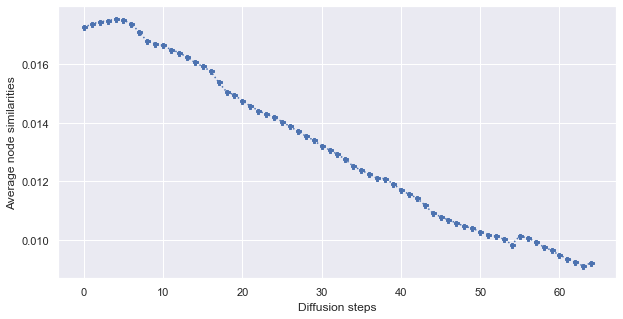

In [248]:
similarities = get_similarities(outputs)
plot_similarities(similarities)

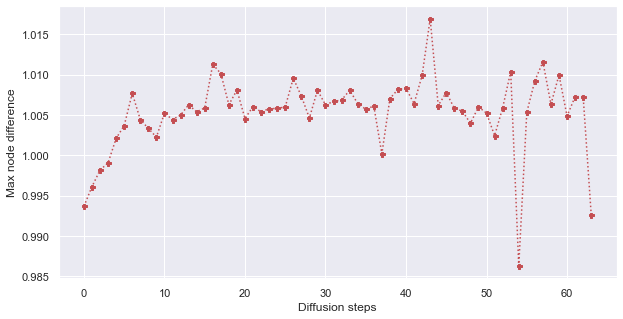

In [249]:
differences = get_differences(outputs)
plot_differences(differences)

In [250]:
outputs = diffuse(F0,As,Ws,diffusion_stepIFT,tau=0.5)

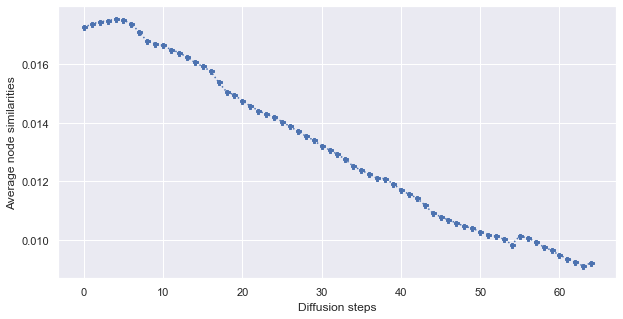

In [251]:
similarities = get_similarities(outputs)
plot_similarities(similarities)

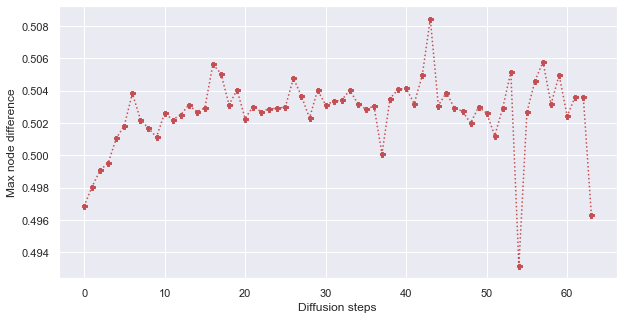

In [252]:
differences = get_differences(outputs)
plot_differences(differences)